
# پروژه پایانی درس سیگنال ها و سیستم ها
## تغییر صدا
در این پروژه به پیاده سازی سیستم زمان گسسته برای تغییر صدا پرداخته میشود
از کاربردهای تبدیل صدا و تغییر پیچ صدا میتوان به نرم افزارهای متن به گفتار و تشخیص و اهراز هویت صدا اشخاص و همچنین تغییر صدا برای مجهول ماندن گوینده آن اشاره کرد



In [82]:
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import pyaudio
import wave
import numpy as np
import scipy.signal as sp
import IPython
import matplotlib.pyplot as plt

یک تابع پیاده سازی می کنیم، جهت رسم تبدیل فوریه ی سیگنال

In [83]:
def draw(voice):
    voice_fft = fft(voice)
    voice_fft = voice_fft[0:len(voice_fft)//2]
    plt.plot(voice_fft)


کانفیگ های ضبط صدا در سکشن زیر آمده است

In [84]:
FORMAT = pyaudio.paInt16  # format of sampling 16 bit int
CHANNELS = 1  # number of channels it means number of sample in every sampling
RATE = 44100  # number of sample in 1 second sampling
CHUNK = 1024  # length of every chunk
RECORD_SECONDS = 5  # time of recording in seconds
WAVE_OUTPUT_FILENAME = "file.wav"  # file name
WAVE_OUTPUT_FILENAME_TARGET = "fileTarget.wav"  # file name

با استفاده از ماژول (پای آدیو) یک استریم می سازیم و به اندازه ی یک چانک از آن بافر میکنیم و آن را در فریم ذخیره می کنیم

سپس آن فریم را در فایل ویو ذخیره می کنیم

In [86]:
audio = pyaudio.PyAudio()


print("recording...")
stream = audio.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=CHUNK
)
# start Recording

frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

# stop Recording
stream.stop_stream()
stream.close()

# storing voice
waveFile = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()
print('finish.')

recording...
finish.


# حالت ساده

فایل ویو ضبط شده را بخش می کند

In [87]:
# reading voice
rate, data = wav.read('file.wav')
print('sampling rate : ', rate)
IPython.display.Audio(data, rate=rate)


sampling rate :  44100


با استفاده از تابع (دراو) تبدیل فوریه ی صوت ضبط شده را رسم می کنیم

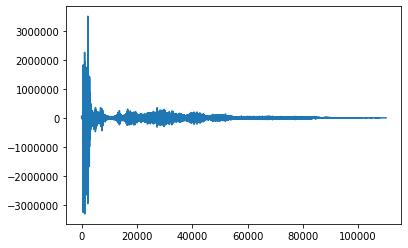

In [64]:
draw(data)

بدلیل اینکه بتوانیم سیستم را بصورت ریل-تایم نیز پیاده سازی کنیم، بجای شیفت در حوزه ی فرکانس و گرفتن تبدیل فوریه معکوس (که نیازمند داشتن تمام سیگنال می باشد) از ضرب در تابع اویلری در سیگنال در حوزه ی زمان استفاده می کنیم.
که با توجه به حقیقی بودن سیگنال تابع اویلی برابر با همان تابع کسینوس می شود
$$
    y[n] = x[n] \, \cos(\omega_0 n)
$$
که نتیجتا موجب شیفت یافتن سیگنال در حوزه ی فرکانس می شود و باعث می شود صدا بم تر یا زیر تر شود.

In [65]:
w =  2 * np.pi * 400 / rate
out = data * np.cos(w * np.arange(0,len(data)))

IPython.display.Audio(out, rate=rate)

سیگنال جدید (شیفت یافته) را رسم میکنیم و میبینیم که شیفت یافته است

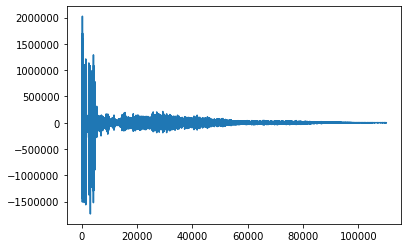

In [66]:
draw(out)

مشابه قبل با مقادیر دیگری نیز شیفت می دهیم و میبینیم که صدا هربار مجددا متفاوت می شود

In [67]:
w =  2 * np.pi * 700 / rate
out = data * np.cos(w * np.arange(0,len(data)))

IPython.display.Audio(out, rate=rate)

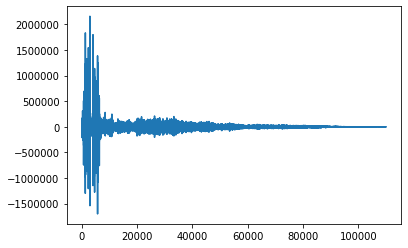

In [68]:
draw(out)

In [69]:
w =  2 * np.pi * 900 / rate
out = data * np.cos(w * np.arange(0,len(data)))

IPython.display.Audio(out, rate=rate)

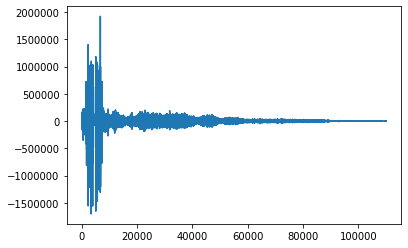

In [70]:
draw(out)

# حالت پیشرفته
برای تغییر یک صدا به صدای دیگر لازم است که پیچ های دو سیگنال را باهم جابجا کنیم (پیچ سیگنال هدف را به جای پیچ سیگنال اولیه قرار می دهیم) که برای این کار نیاز به یک تابع برای یافتن پیچ ها و یک تابع برای تغییر پیچ ها داریم.
برای این کار ابتدا پیچ های هر دو صدا را می یابیم و سپس پیچ سیگنال اولیه را به اندازه ی اختلاف پیچش با پیچ سیگنال هدف شیفت می دهیم 

پیچ درواقع درک انسان از زیر و بمی صداست که با فرکانس متفاوت است و به همین دلیل است که با تغییر فرکانس خالی لزوما صدا تبدیل به صدای هدف نمی شود

پیچ تابعی از فرکانس و تراز صدا می باشد

درواقع آوا ها و صدا ها و نت های موسیقی که گوش انسان آن ها را تشخیص می دهد دارای یک ساختار متناوب (پریودیک) در حوزه ی فرکانس می باشند

برای تغییر پیچ ها این کار را در حوزه ی فرکانسی انجام میدهیم

برای تابع شیفت پیچ از الگوریتم (دی اف تی)‌استفاده مینماییم

بر روی تبدیل فوریه ی سیگنال از چپ به راست، اولین پیک را پیک اساسی (فاندیمنتال) می نامیم و بقیه را پیک های جزیی (پارشیال) می نامیم

این کار را در واقع بر روی هر نت یا آوا جداگانه انجام می دهیم

سپس هر کدام را جداگانه پیچ می دهیم و حاصل آن ها می شود صدای پیچ یافته

برای گرفتن این آواها از یک صوت، آن را به قسمت های کوچک تقسیم می کنیم که این قسمت ها باید به شکلی باشند که نه آنقدر کوچک باشند که آوا ناقص شود و تبدیل فوریه ی ما خراب شود و نه آنقدر بزرگ باشند که بیش از یک آوا ضبط شود که اصولا بین ۵۰ تا ۱۰۰ میلی ثانیه می باشد 

اگر مشابه روش قبل عمل کرده و صرفا فرکانس ها را جابجا کنیم بدلیل بهم ریختن هارمونی سیگنال صدا حالت غیر واقعی پیدا می کند ( چرا که آوا های ایجاد شده توسط انسان و ساز ها همگی هارمونیک هستند) اما در این روش چون ابتدا آوا ها را از هم جدا می کنیم و هرکدام را جداگانه پیچ می کنیم حالت هارمونیک آن ها حفظ می شود و صدا حالت واقعی پیدا می کند

سیگنال صوتی صحبت انسان هارمونیک نیست بهمین دلیل سیگنال صوتی انسان را بخش بخش می کنیم (روی آن پنجره گذاری می کنیم) تا آوا ها که هارمونیک هستند را بدست بیاوریم

برای درست پیچ کردن باید هر سگمنت از سیگنال را در حوزه ی فرکانس در امتداد محور فرکانس به اندازه ی بازه ی سیگنال اصلی گسترش دهیم تا پس از تغییر پیچ همچنان هارمونیک باقی بماند 

In [88]:
def DFT_rescale(x, f):
    X = np.fft.fft(x)
    # separate even and odd lengths
    parity = (len(X) % 2 == 0)
    N = int(len(X) / 2) + 1 if parity else (len(X) + 1) / 2
    Y = np.zeros(N, dtype=np.complex)
    # work only in the first half of the DFT vector since input is real
    for n in range(0, N):
        # accumulate original frequency bins into rescaled bins
        ix = int(n * f)
        if ix < N:
            Y[ix] += X[n]
    # now rebuild a Hermitian-symmetric DFT
    Y = np.r_[Y, np.conj(Y[-2:0:-1])] if parity else np.r_[Y, np.conj(Y[-1:0:-1])]
    return np.real(np.fft.ifft(Y))

In [89]:
# converting milliseconds to samples
def ms2smp(ms, Fs):
    return int(float(Fs) * float(ms) / 1000.0)

In [90]:
# trapezoid window
def win_taper(N, a):
    R = int(N * a / 2)
    r = np.arange(0, R) / float(R)
    win = np.r_[r, np.ones(N - 2*R), r[::-1]]
    stride = N - R - 1
    return win, stride

حال پنجره هایی بر روی سیگنال تعریف می کنیم با استفاده از توابع بالا

حالا بر روی تمامی این پنجره ها تابع ری-اسکیل را فراخوانی می کنیم و آن ها را گسترش می دهیم و با در نظر گرفتن مقدار معینی به عنوان اور-لپ آن ها را با هم جمع می کنیم که سیگنال حاصل ما را نتیجه می دهند

دلیل این اور-لپ این است که پیوستگی بین آوا ها را پوشش دهیم

In [91]:
def DFT_pshift(x, f, G, overlap=0):
    N = len(x)
    y = np.zeros(N)
    win, stride = win_taper(G, overlap)
    for n in range(0, len(x) - G, stride):
        w = DFT_rescale(x[n:n+G] * win, f)
        y[n:n+G] += w * win
    return y

نتیجه ی پیچ شده ی فایل صوتی توسط مکانیزم بالا را با دو مقدار متفاوت امتحان می کنیم

* در فرکانس های بالا تر بدلیل گسترده تر بودن سیگنال در حوزه فرکانس از اور-لپ بیشتر استفاده می کنیم

In [93]:
IPython.display.Audio(DFT_pshift(data, 1.5, ms2smp(40, rate), 0.4), rate=rate)

In [94]:
IPython.display.Audio(DFT_pshift(data, 0.6, ms2smp(40, rate), 0.2), rate=rate)

حال فایل صوتی هدف را ضبط می کنیم

In [95]:
WAVE_OUTPUT_FILENAME_TARGET = "fileTarget.wav"  # file name
audio = pyaudio.PyAudio()


print("recording...")
stream = audio.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=CHUNK
)
# start Recording

frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

# stop Recording
stream.stop_stream()
stream.close()

# storing voice
waveFile = wave.open(WAVE_OUTPUT_FILENAME_TARGET, 'wb')
waveFile.setnchannels(CHANNELS)
waveFile.setsampwidth(audio.get_sample_size(FORMAT))
waveFile.setframerate(RATE)
waveFile.writeframes(b''.join(frames))
waveFile.close()
print('finish.')

recording...
finish.


صوت هدف

In [97]:
# reading target voice
rateTarget, dataTarget = wav.read('fileTarget.wav')
print('sampling rate : ', rateTarget)
IPython.display.Audio(dataTarget, rate=rateTarget)



sampling rate :  44100


صوت مبدا

In [99]:
rate, data = wav.read('file.wav')
print('sampling rate : ', rate)
IPython.display.Audio(data, rate=rate)

sampling rate :  44100


با استفاده الگوریتم (وای ای ای پی تی) پیچ هر دو صوت را محاسبه میکنیم و میانگین پیچ آن ها را محاسبه می کنیم

In [100]:
import amfm_decompy.basic_tools as basic
import amfm_decompy.pYAAPT as pYAAPT

def YAAPT(Fn):
    # load audio
    signal = basic.SignalObj(Fn)
    filename = Fn
    # YAAPT pitches
    pitchY = pYAAPT.yaapt(signal, frame_length=40,
                      tda_frame_length=40, f0_min=75, f0_max=600)

#     print(pitchY.samp_values)

    # plot

    fig = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 8))
    plt.plot(pitchY.samp_values, label='YAAPT', color='blue')
    # plt.savefig('YAAPT.png')
    plt.show()
    return np.average(pitchY.samp_values)


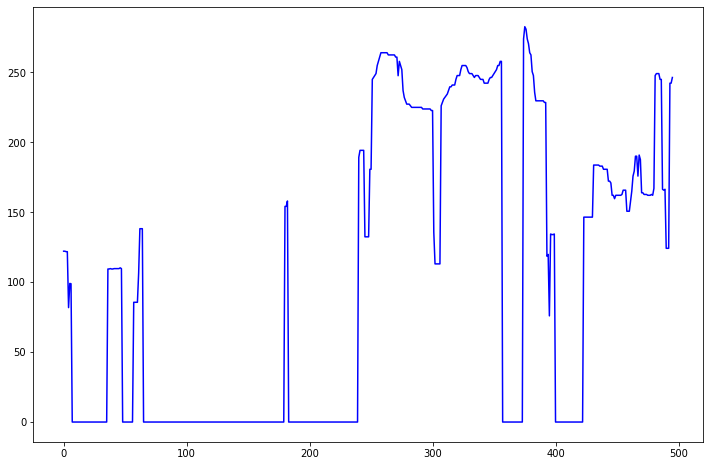

average pitch:  98.18265026656184


In [101]:
file_pitch_avg = YAAPT('file.wav')
print('average pitch: ',file_pitch_avg)

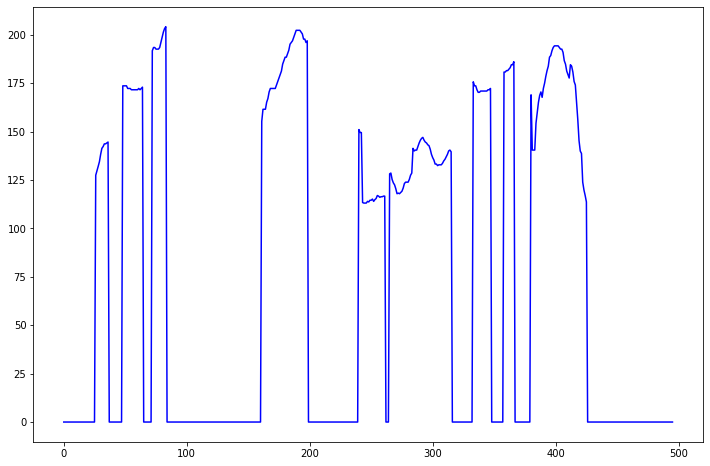

average pitch:  71.10241855078223


In [102]:
file_target_pitch_avg = YAAPT('fileTarget.wav')
print('average pitch: ',file_target_pitch_avg)

سیگنال صوت مبدا را به مقدار تفاضل پیچ میانگین سیگنال هدف از سیگنال مبدا (پیچش را شیفت میدهیم) پیچ میکنیم

In [104]:
IPython.display.Audio(DFT_pshift(data, (file_target_pitch_avg-file_pitch_avg), ms2smp(40, rate), 0.4), rate=rate)